In [1]:
import clickhouse_connect
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math
from collections import Counter
from itertools import groupby
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
client = clickhouse_connect.get_client(
    host='localhost',
    port=8123,
    username="admin",
    password="12345678"
)

# Explore Data Analysis

In [3]:
number_comment = client.query("select count(*) from comments")
number_channel = client.query("select count(distinct channel_name) from comments")
print(f"Number of comment is {number_comment.result_columns[0][0]}\nNumber of channel is {number_channel.result_columns[0][0]}")

Number of comment is 13317124
Number of channel is 862


## Distribution of comment channel

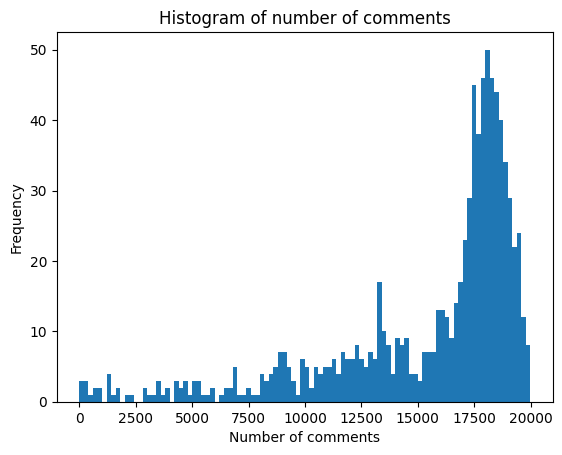

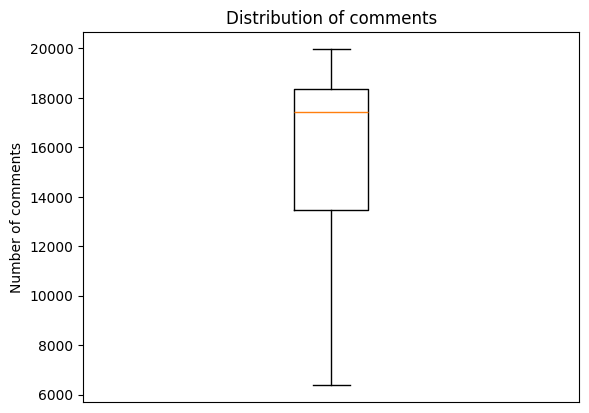

In [4]:
channel_comments = client.query_df("""
select channel_name, count(*) as number_comments
from comments
group by channel_name""")
channel_comments.sort_values(by="number_comments", inplace=True)
channel_comments.reset_index(inplace=True)
# Line chart
plt.figure()
plt.hist(channel_comments["number_comments"], bins=100)
plt.xlabel("Number of comments")
plt.ylabel("Frequency")
plt.title("Histogram of number of comments")
plt.show()
# Box-plot
plt.figure()
plt.boxplot(channel_comments["number_comments"], showfliers=False)
plt.gca().xaxis.set_visible(False)
plt.ylabel("Number of comments")
plt.title("Distribution of comments")
plt.show()


## Distibution of author to comments

In [12]:
number_author_comments_once = client.query("""select count(*)
from 
(select author, count(comment_id) as num from comments
group by author
having num = 1)
""")
print(f"Number author just comment only one is {number_author_comments_once.result_columns[0][0]}")
author_comments =  client.query_df("""
select author, count(comment_id) as number_comments from comments
group by author
""")
author_comments.sort_values(by="number_comments", inplace=True)
author_comments.reset_index(inplace=True)

Number author just comment only one is 9087328


group
1     9087328
2     1132867
3      208733
4       78381
5       31083
6       17642
7+      42761
Name: count, dtype: int64


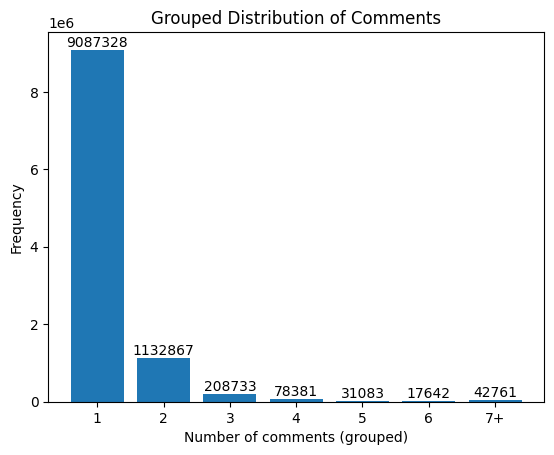

In [13]:
def group_comments(x):
    if x <= 6:
        return str(x)
    else:
        return "7+"

author_comments["group"] = author_comments["number_comments"].apply(group_comments)

group_count = author_comments["group"].value_counts().sort_index()
print(group_count)

plt.figure()
bars = plt.bar(group_count.index, group_count.values)

plt.xlabel("Number of comments (grouped)")
plt.ylabel("Frequency")
plt.title("Grouped Distribution of Comments")

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.show()

## Length Char Distribution

In [14]:
lenghchar_distribution = client.query_df("""
with le as (select char_length(comment_text) as l from comments)
select l, count(*) as number
from le
group by l
order by l""")

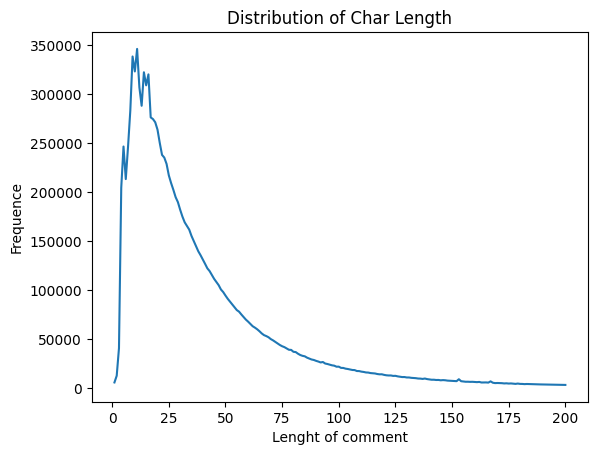

In [15]:
plt.figure()
plt.plot(lenghchar_distribution['l'][:200], lenghchar_distribution['number'][:200])
plt.xlabel("Lenght of comment")
plt.ylabel("Frequence")
plt.title("Distribution of Char Length")
plt.show()

# Data Processing

In [ ]:
comments = client.query_df("select channel_name, comment_text, likes from comments")

## Spamming Preprocessing

In [20]:
#Repetition-based spam (ex. lelellelelelelele)
def unique_token_ratio(text):
    tokens = text.split()
    if not tokens:
        return 0
    return len(set(tokens)) / len(tokens)

def repeated_substring(text):
    n = len(text)
    for i in range(1, n // 2 + 1):
        if text == text[:i] * (n // i):
            return True
    return False

def max_char_run_ratio(text):
    runs = [len(list(g)) for _, g in groupby(text)]
    return max(runs) / len(text)

#Flooding (ex. 1 2 3 4 5 6.....)
def numeric_token_ratio(text):
    tokens = text.split()
    nums = [t for t in tokens if re.fullmatch(r"\d+", t)]
    return len(nums) / len(tokens) if tokens else 0

def is_sequential_numbers(nums):
    return all(nums[i+1] - nums[i] == 1 for i in range(len(nums)-1))

#Length-based Spamming
def avg_token_length(text):
    tokens = text.split()
    return sum(len(t) for t in tokens) / len(tokens)

def punctuation_ratio(text):
    import string
    punct = set(string.punctuation)
    return sum(c in punct for c in text) / len(text)

#Low entropy 
def char_entropy(text):
    counts = Counter(text)
    total = len(text)
    return -sum((c/total) * math.log2(c/total) for c in counts.values())

#Template
SPAM_PATTERNS = [
    "thumbs up if",
    "like if",
    "who is here",
    "anyone watching in"
]

def template_spam(text):
    t = text.lower()
    return any(p in t for p in SPAM_PATTERNS)

#Emoji Spamming
def emoji_ratio(text):
    return sum(ord(c) > 10000 for c in text) / len(text)

# URL spamming
def url_count(text):
    import re
    return len(re.findall(r"http[s]?://", text))

In [23]:
def df_batches(df, batch_size):
    for start in range(0, len(df), batch_size):
        yield df.iloc[start:start + batch_size]

def is_spam(text: str) -> bool:
    if not isinstance(text, str) or len(text.strip()) <= 3:
        return True   # text rỗng → loại

    t = text.lower()

    if unique_token_ratio(t) < 0.15:
        return True

    if repeated_substring(t):
        return True

    if max_char_run_ratio(t) > 0.30:
        return True

    if numeric_token_ratio(t) > 0.60:
        return True

    if avg_token_length(t) < 2.0:
        return True

    if punctuation_ratio(t) > 0.40:
        return True

    if len(t) > 20 and char_entropy(t) < 3.0:
        return True

    if template_spam(t):
        return True

    if emoji_ratio(t) > 0.30:
        return True
    
    if url_count(t) >= 1:
        return True

    return False

In [ ]:
batch_size = 5000
clean_batches = []

total_rows = 0
total_removed = 0
batch_id = 0

for batch in df_batches(comments, batch_size):
    batch_id += 1
    batch_rows = len(batch)

    spam_mask = batch["comment_text"].apply(is_spam)
    removed = spam_mask.sum()

    clean = batch[~spam_mask]
    clean_batches.append(clean)

    total_rows += batch_rows
    total_removed += removed

    print(
        f"[Batch {batch_id}] "
        f"rows={batch_rows} | "
        f"removed={removed} ({removed/batch_rows:.2%}) | "
        f"kept={batch_rows-removed}"
    )

comments_clean = pd.concat(clean_batches, ignore_index=True)

print("\n=== SUMMARY ===")
print(f"Total rows processed : {total_rows}")
print(f"Total removed (spam) : {total_removed}")
print(f"Final clean rows    : {len(comments_clean)}")


## Load into Warehouse

In [29]:
# query_cmd = """
# CREATE TABLE comment_clean (
#     channel_name String,
#     comment_text String,
#     likes UInt32
# ) ENGINE = MergeTree()
# ORDER BY channel_name;"""
# client.command(query_cmd)

In [ ]:
# client.insert_df('comment_clean', comments_clean)

## Explore Data After Preprocessing

In [59]:
number_comment = client.query("select count(*) from comment_clean")
number_channel = client.query("select count(distinct channel_name) from comment_clean")
print(f"Number of comment is {number_comment.result_columns[0][0]}\nNumber of channel is {number_channel.result_columns[0][0]}")

Number of comment is 10527749
Number of channel is 862


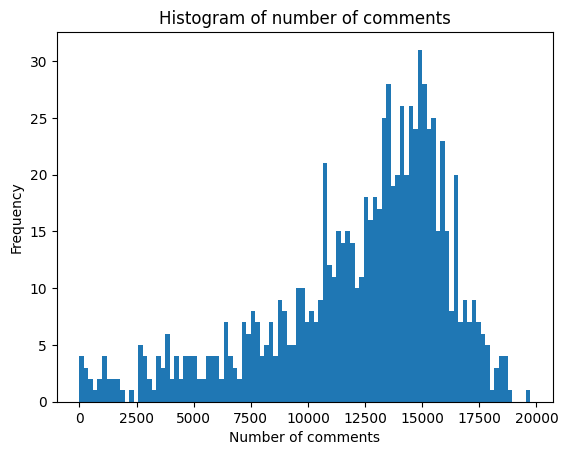

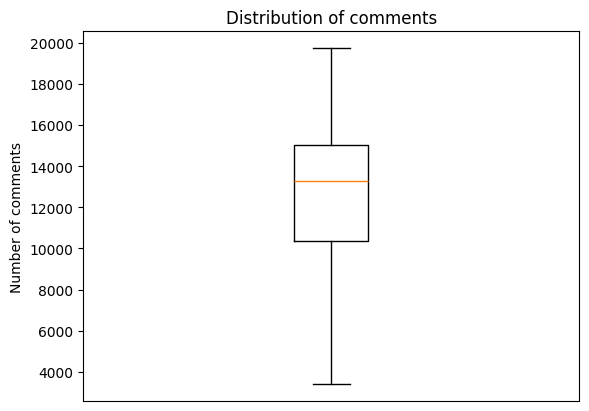

In [60]:
channel_comments = client.query_df("""
select channel_name, count(*) as number_comments
from comment_clean
group by channel_name""")
channel_comments.sort_values(by="number_comments", inplace=True)
channel_comments.reset_index(inplace=True)
# Line chart
plt.figure()
plt.hist(channel_comments["number_comments"], bins=100)
plt.xlabel("Number of comments")
plt.ylabel("Frequency")
plt.title("Histogram of number of comments")
plt.show()
# Box-plot
plt.figure()
plt.boxplot(channel_comments["number_comments"], showfliers=False)
plt.gca().xaxis.set_visible(False)
plt.ylabel("Number of comments")
plt.title("Distribution of comments")
plt.show()


## Filter channel with small amount of comments

In [61]:
channels = client.query_df("select channel_name from comment_clean group by channel_name having count(*) > 2500")
channels

,channel_name
0,Barvina
1,Elli Di
2,Kadosha
3,Horia
4,Lauv
...,...
833,หนูม่วง คำหลู่
834,Cookies Cupcakes and Cardio
835,Escorpión Dorado el Chido
836,Amr Maskoun | عمرو مسكون


## Embedding Comment

### MiniLM-L6-v2

In [2]:
embed_ver1 = np.load("channel_embeddings_all-MiniLM-L6-v2.npy", allow_pickle=True)
channel = pd.read_csv("channels_all-MiniLM-L6-v2.txt", header=None)[0].to_list()[1:]
# Tạo DataFrame
data_ver1 = pd.DataFrame({
    "channel_name": channel,
    "embedding": list(embed_ver1)
})


In [47]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(embed_ver1)
    
    distortions.append(sum(np.min(cdist(embed_ver1, kmeanModel.cluster_centers_, 'cosine'), axis=1)**2) / embed_ver1.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

Distortion values:
1 : 0.17253981138246885
2 : 0.09804635036811213
3 : 0.07502180312865901
4 : 0.07076787256456576
5 : 0.06543146481169533
6 : 0.052297778835618036
7 : 0.051042130202639834
8 : 0.042966686669021446
9 : 0.041711468313908394
10 : 0.040685520524259736
11 : 0.03846356160675712
12 : 0.03885094052074474
13 : 0.0353627243766472
14 : 0.03392337075373001
15 : 0.03278643522753738
16 : 0.03172591319936023
17 : 0.031039798324263606
18 : 0.030505119634185313
19 : 0.030460233203774747


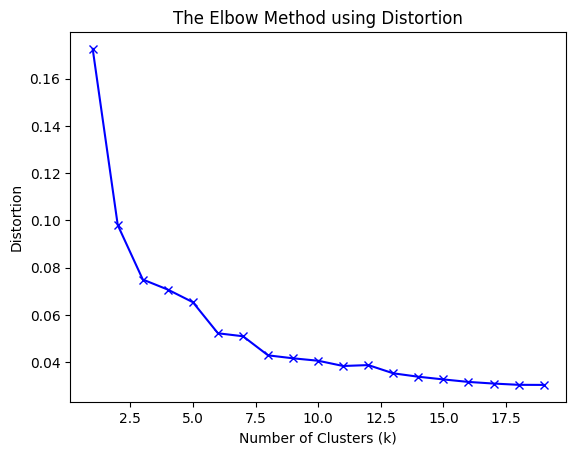

In [48]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Inertia values:
1 : 205.85264942012137
2 : 155.72627307197718
3 : 131.03404808043615
4 : 124.0345853507778
5 : 119.74653473578341
6 : 104.42480462511043
7 : 99.52403141675141
8 : 90.2463491708223
9 : 85.33728051469762
10 : 83.86936501546401
11 : 77.24126684655367
12 : 80.20679096455493
13 : 74.61933022203979
14 : 73.49197250741022
15 : 72.60566837528924
16 : 72.17455777931033
17 : 70.54080327129527
18 : 69.18232818882835
19 : 68.92533961213249


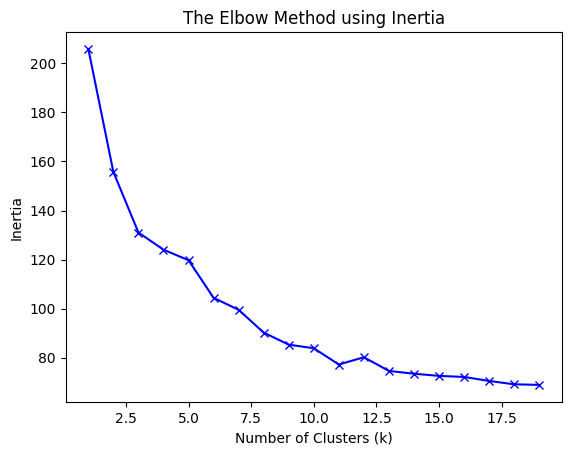

In [49]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

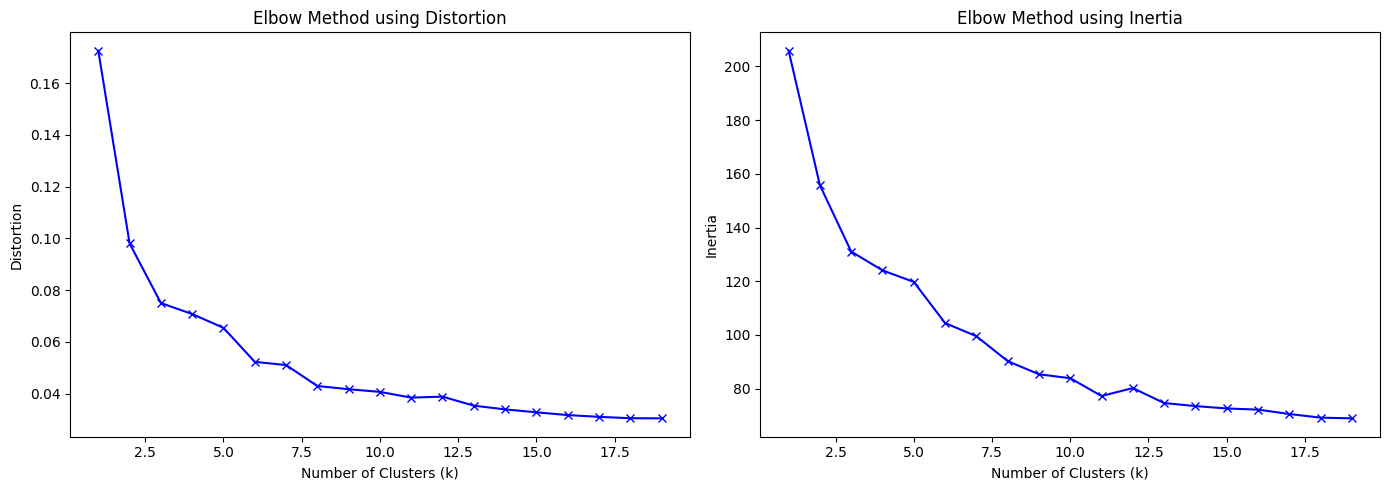

In [50]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Distortion plot ----
axes[0].plot(K, distortions, 'bx-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Distortion')
axes[0].set_title('Elbow Method using Distortion')

# ---- Inertia plot ----
axes[1].plot(K, inertias, 'bx-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Elbow Method using Inertia')

plt.tight_layout()
plt.show()


In [89]:
from sklearn.metrics import silhouette_score

K = [3, 6, 8, 13]
kmeans = KMeans(n_clusters=k, random_state=42, verbose=1)
clusters = [KMeans(n_clusters=k, random_state=42).fit_predict(embed_ver1) for k in K]
scores = [silhouette_score(embed_ver1, cluster, metric='cosine') for cluster in clusters]
scores

[0.40887542574138763,
 0.33584701582524773,
 0.36154825132962526,
 0.28306705344919314]

In [105]:
from sklearn.metrics import adjusted_rand_score
def kmeans_stability(X, k, runs=100):
    base = KMeans(k).fit_predict(X)
    scores = []
    for _ in range(runs):
        idx = np.random.choice(len(X), int(0.8*len(X)), replace=False)
        sub = KMeans(k).fit_predict(X[idx])
        scores.append(adjusted_rand_score(base[idx], sub))
    return np.mean(scores)
[kmeans_stability(embed_ver1, k) for k in K]

[np.float64(0.8323452453489278),
 np.float64(0.7550925834262401),
 np.float64(0.7726130716273032),
 np.float64(0.7421031785564677)]

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
def intra_inter_similarity(embeddings, labels):
    intra, inter = [], []
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            sim = cosine_similarity(
                embeddings[i].reshape(1,-1),
                embeddings[j].reshape(1,-1)
            )[0][0]
            if labels[i] == labels[j]:
                intra.append(sim)
            else:
                inter.append(sim)
    return np.mean(intra), np.mean(inter)
[intra_inter_similarity(embed_ver1, cluster) for cluster in clusters]

[(np.float64(0.5667754191698489), np.float64(0.24353927071433973)),
 (np.float64(0.6320911118903028), np.float64(0.28848626783814946)),
 (np.float64(0.6888863026015433), np.float64(0.30324910674107247)),
 (np.float64(0.7220184813729695), np.float64(0.3351624237492875))]

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def intra_cluster_similarity(X, labels):
    scores = {}
    for c in np.unique(labels):
        if c == -1:  # bỏ noise nếu là HDBSCAN
            continue
        idx = labels == c
        Xc = X[idx]

        centroid = Xc.mean(axis=0, keepdims=True)
        sim = cosine_similarity(Xc, centroid).mean()
        scores[c] = sim
    return scores

def overall_sematic_coherence(X, labels):
    scores = intra_cluster_similarity(X, labels)
    overall_score = np.mean(list(scores.values()))
    return overall_score

[overall_sematic_coherence(embed_ver1, cluster) for cluster in clusters]

[np.float64(0.7627964503677752),
 np.float64(0.8241574744464689),
 np.float64(0.8533955881228188),
 np.float64(0.8804049007414162)]

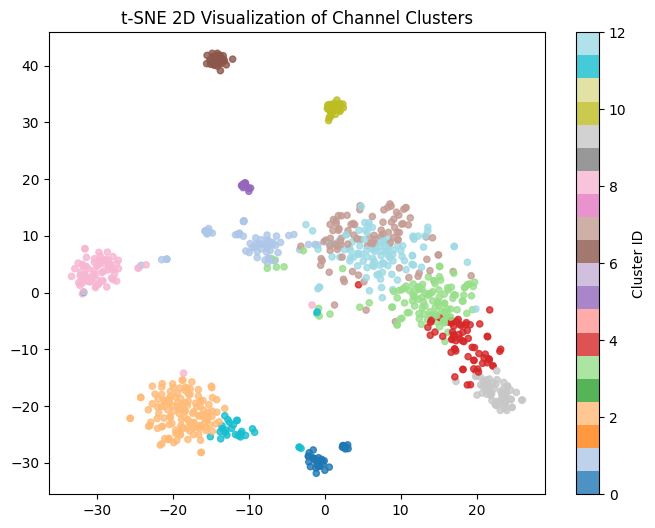

In [56]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. PCA trước
#X_pca = PCA(n_components=50, random_state=42).fit_transform(embed_ver1)

# 2. t-SNE 2D
tsne_2d = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne_2d = tsne_2d.fit_transform(embed_ver1)

# 3. Plot
plt.figure(figsize=(8,6))
plt.scatter(
    X_tsne_2d[:,0],
    X_tsne_2d[:,1],
    c=clusters,
    cmap='tab20',
    s=20,
    alpha=0.8
)
plt.title("t-SNE 2D Visualization of Channel Clusters")
plt.colorbar(label="Cluster ID")
plt.show()


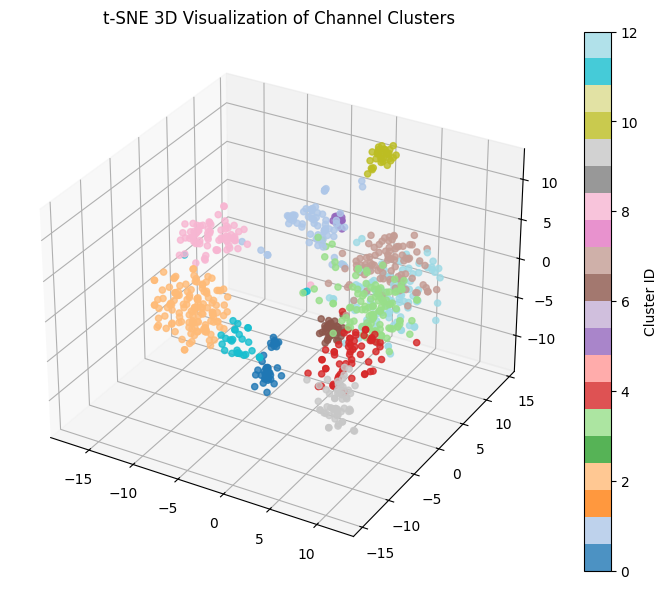

In [57]:
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne_3d = tsne_3d.fit_transform(embed_ver1)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X_tsne_3d[:,0],
    X_tsne_3d[:,1],
    X_tsne_3d[:,2],
    c=clusters,
    cmap='tab20',
    s=20,
    alpha=0.8
)

ax.set_title("t-SNE 3D Visualization of Channel Clusters")
fig.colorbar(sc, label="Cluster ID")
plt.show()


### infloat/e5-small

In [3]:
embed_ver2 = np.load("channel_embeddings_e5-small.npy", allow_pickle=True)
channel = pd.read_csv("channels_e5-small.txt", header=None)[0].to_list()[1:]
# Tạo DataFrame
data_ver2 = pd.DataFrame({
    "channel_name": channel,
    "embedding": list(embed_ver2)
})

In [109]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(embed_ver2)
    
    distortions.append(sum(np.min(cdist(embed_ver2, kmeanModel.cluster_centers_, 'cosine'), axis=1)**2) / embed_ver2.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

Distortion values:
1 : 0.0015863310497359027
2 : 0.0011305913453271122
3 : 0.0008740002726123937
4 : 0.0007899322480098205
5 : 0.000666853583781657
6 : 0.0006148071775123216
7 : 0.0005850065559668641
8 : 0.0005727703459063919
9 : 0.0005427395048784714
10 : 0.0005242460848193332
11 : 0.0005198472205055911
12 : 0.0005066348211322244
13 : 0.00048363163390753453
14 : 0.0004558381288840499
15 : 0.00044530748359164116
16 : 0.00043213282171690096
17 : 0.00042706697355379984
18 : 0.00041776202106752594
19 : 0.00041355856478628774


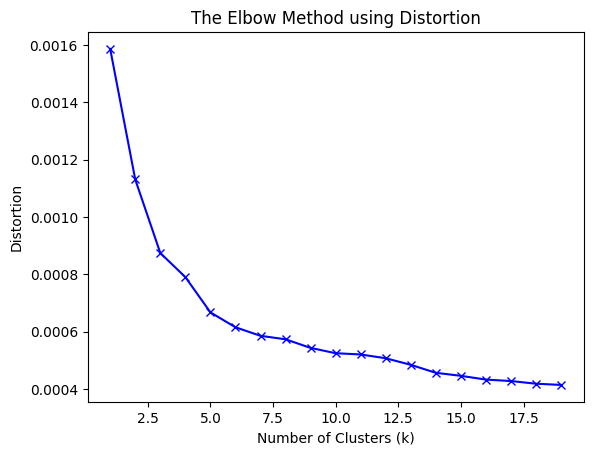

In [75]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Inertia values:
1 : 48.50860983404701
2 : 41.23969074778289
3 : 34.89096290111199
4 : 33.004975260183876
5 : 29.464999462022927
6 : 27.646479926714907
7 : 26.04118733124556
8 : 26.252891758853206
9 : 25.27858115708845
10 : 24.78282260125023
11 : 24.677109318311395
12 : 24.344167299619816
13 : 22.683676795154916
14 : 21.760832124706837
15 : 21.471569423889953
16 : 21.0462689917926
17 : 20.85215239328501
18 : 20.486335983776346
19 : 20.24214220995066


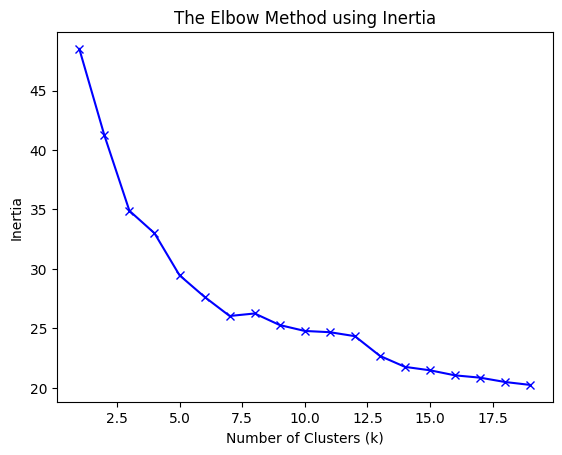

In [76]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

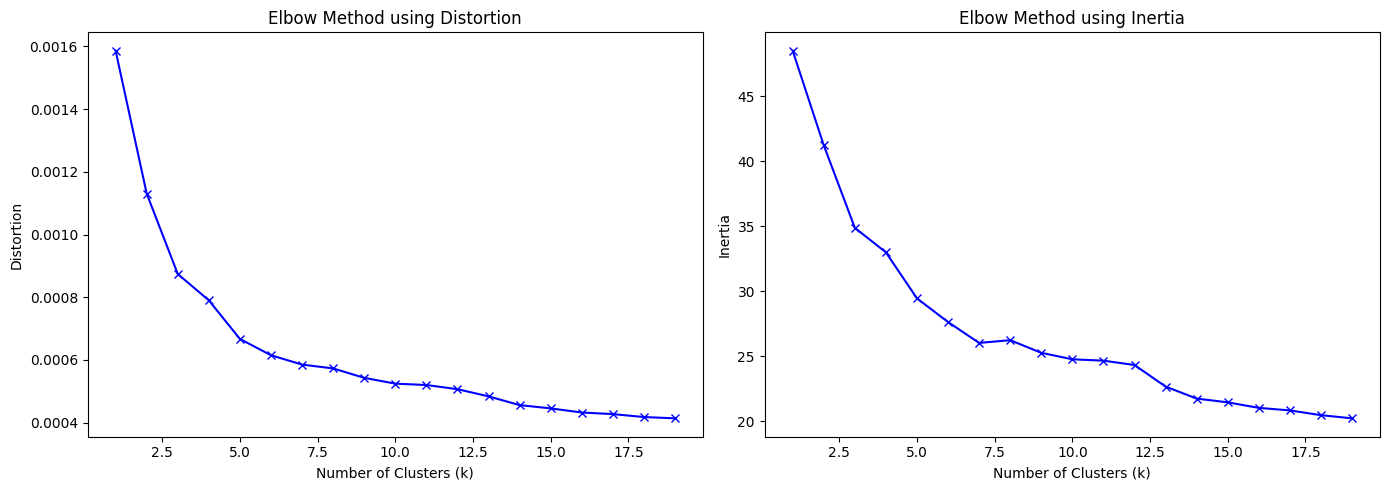

In [77]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Distortion plot ----
axes[0].plot(K, distortions, 'bx-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Distortion')
axes[0].set_title('Elbow Method using Distortion')

# ---- Inertia plot ----
axes[1].plot(K, inertias, 'bx-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Elbow Method using Inertia')

plt.tight_layout()
plt.show()


In [112]:
from sklearn.metrics import silhouette_score

K = [3,7,9, 14]
kmeans = KMeans(n_clusters=k, random_state=42, verbose=1)
clusters = [KMeans(n_clusters=k, random_state=42).fit_predict(embed_ver2) for k in K]
scores = [silhouette_score(embed_ver2, cluster, metric='cosine') for cluster in clusters]
scores

[0.32442565369441373,
 0.34373959173249974,
 0.26141150932461255,
 0.27988461122784175]

In [85]:
# from sklearn.metrics import davies_bouldin_score
# dbi_score = davies_bouldin_score(embed_ver2, clusters)
# dbi_score

In [113]:
from sklearn.metrics.pairwise import cosine_similarity
def intra_inter_similarity(embeddings, labels):
    intra, inter = [], []
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            sim = cosine_similarity(
                embeddings[i].reshape(1,-1),
                embeddings[j].reshape(1,-1)
            )[0][0]
            if labels[i] == labels[j]:
                intra.append(sim)
            else:
                inter.append(sim)
    return np.mean(intra), np.mean(inter)
[intra_inter_similarity(embed_ver2, cluster) for cluster in clusters]

[(np.float64(0.950465003564071), np.float64(0.9179000450652717)),
 (np.float64(0.9599485950119236), np.float64(0.923978511964535)),
 (np.float64(0.9629382365957817), np.float64(0.926902388289393)),
 (np.float64(0.966852467588336), np.float64(0.9281147939248684))]

In [114]:
[overall_sematic_coherence(embed_ver2, cluster) for cluster in clusters]

[np.float64(0.9754317421639794),
 np.float64(0.9841474701978472),
 np.float64(0.982861495732102),
 np.float64(0.9862691716801856)]

In [115]:
from sklearn.metrics import adjusted_rand_score
def kmeans_stability(X, k, runs=100):
    base = KMeans(k).fit_predict(X)
    scores = []
    for _ in range(runs):
        idx = np.random.choice(len(X), int(0.8*len(X)), replace=False)
        sub = KMeans(k).fit_predict(X[idx])
        scores.append(adjusted_rand_score(base[idx], sub))
    return np.mean(scores)
[kmeans_stability(embed_ver2, k) for k in K]

[np.float64(0.6395652833365049),
 np.float64(0.7135272762535385),
 np.float64(0.6279891319155191),
 np.float64(0.6332763664321557)]

In [117]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. PCA trước


# 2. t-SNE 2D
tsne_2d = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne_2d = tsne_2d.fit_transform(embed_ver2)

# 3. Plot
plt.figure(figsize=(8,6))
plt.scatter(
    X_tsne_2d[:,0],
    X_tsne_2d[:,1],
    c=clusters,
    cmap='tab20',
    s=20,
    alpha=0.8
)
plt.title("t-SNE 2D Visualization of Channel Clusters")
plt.colorbar(label="Cluster ID")
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3077604907.py, line 9)

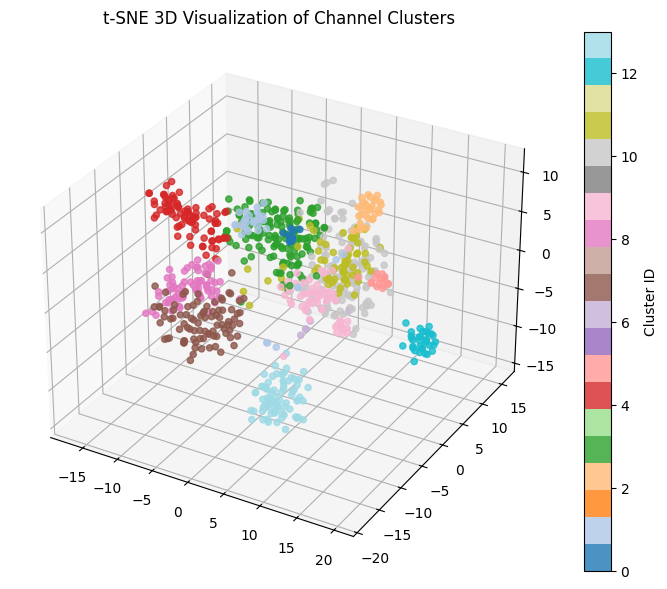

In [69]:
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne_3d = tsne_3d.fit_transform(embed_ver2)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X_tsne_3d[:,0],
    X_tsne_3d[:,1],
    X_tsne_3d[:,2],
    c=clusters,
    cmap='tab20',
    s=20,
    alpha=0.8
)

ax.set_title("t-SNE 3D Visualization of Channel Clusters")
fig.colorbar(sc, label="Cluster ID")
plt.show()


# Conclusion

In [4]:
cluster_MiniLM = KMeans(n_clusters= 8).fit_predict(embed_ver1)
cluster_E5 = KMeans(n_clusters=7).fit_predict(embed_ver2)


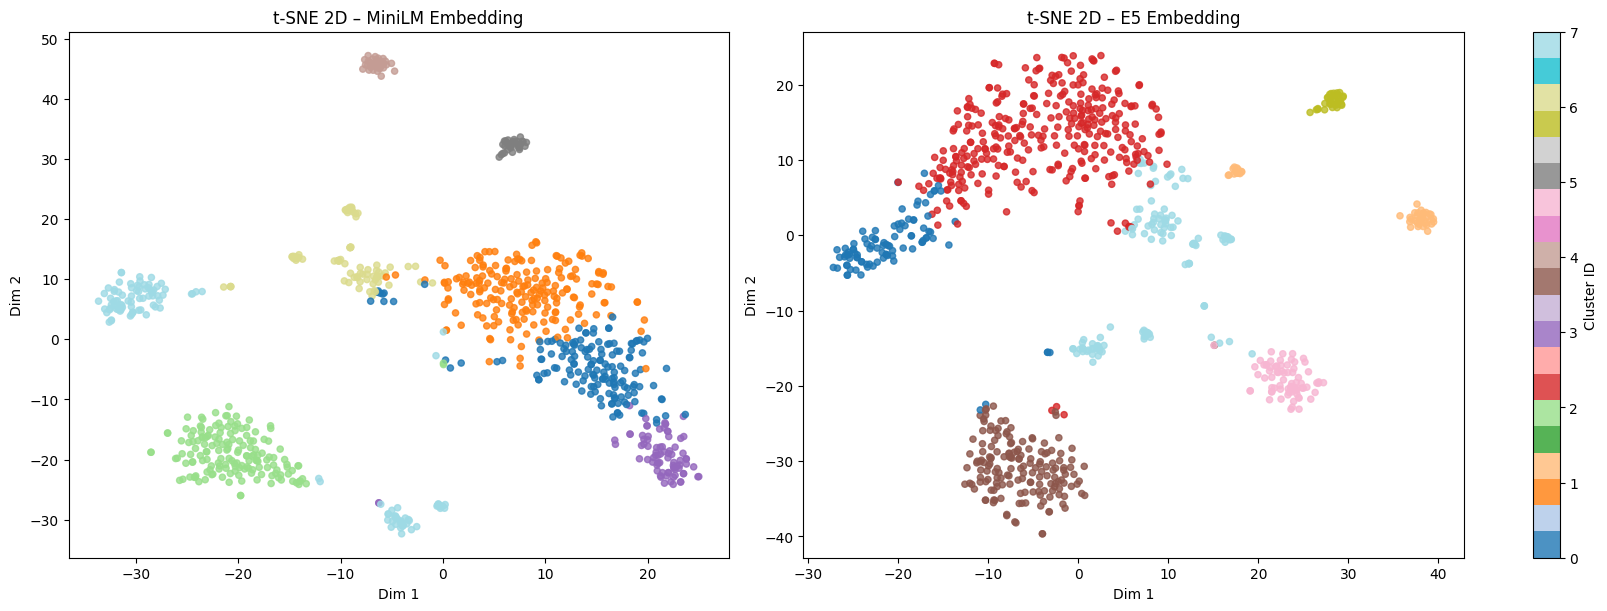

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---- Figure ----
fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 6),
    constrained_layout=True
)

# ---- PCA (preprocessing for t-SNE) ----
pca = PCA(n_components=128, random_state=42)

X_pca_MiniLM = pca.fit_transform(embed_ver1)
X_pca_E5 = pca.fit_transform(embed_ver2)

# ---- t-SNE ----
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne_2d_MiniLM = tsne.fit_transform(X_pca_MiniLM)
X_tsne_2d_E5 = tsne.fit_transform(X_pca_E5)

# ---- Plot MiniLM ----
sc1 = axes[0].scatter(
    X_tsne_2d_MiniLM[:, 0],
    X_tsne_2d_MiniLM[:, 1],
    c=cluster_MiniLM,
    cmap='tab20',
    s=20,
    alpha=0.8
)
axes[0].set_title("t-SNE 2D – MiniLM Embedding")
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

# ---- Plot E5 ----
sc2 = axes[1].scatter(
    X_tsne_2d_E5[:, 0],
    X_tsne_2d_E5[:, 1],
    c=cluster_E5,
    cmap='tab20',
    s=20,
    alpha=0.8
)
axes[1].set_title("t-SNE 2D – E5 Embedding")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

# ---- Shared colorbar ----
fig.colorbar(sc1, ax=axes, label="Cluster ID")

plt.show()


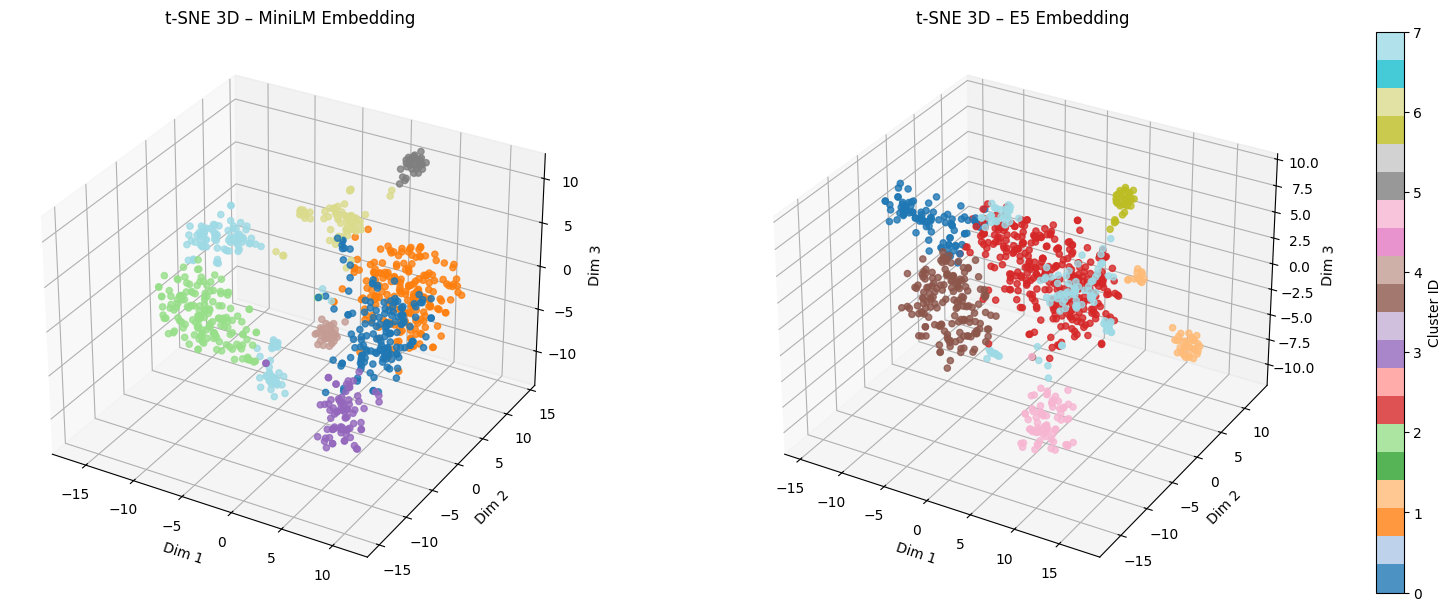

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---- Figure ----
fig = plt.figure(figsize=(16, 6), constrained_layout=True)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# ---- PCA preprocessing ----
pca = PCA(n_components=128, random_state=42)

X_pca_MiniLM = pca.fit_transform(embed_ver1)
X_pca_E5 = pca.fit_transform(embed_ver2)

# ---- t-SNE 3D ----
tsne_3d = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne_3d_MiniLM = tsne_3d.fit_transform(X_pca_MiniLM)
X_tsne_3d_E5 = tsne_3d.fit_transform(X_pca_E5)

# ---- Plot MiniLM ----
sc1 = ax1.scatter(
    X_tsne_3d_MiniLM[:, 0],
    X_tsne_3d_MiniLM[:, 1],
    X_tsne_3d_MiniLM[:, 2],
    c=cluster_MiniLM,
    cmap='tab20',
    s=20,
    alpha=0.8
)

ax1.set_title("t-SNE 3D – MiniLM Embedding")
ax1.set_xlabel("Dim 1")
ax1.set_ylabel("Dim 2")
ax1.set_zlabel("Dim 3")

# ---- Plot E5 ----
sc2 = ax2.scatter(
    X_tsne_3d_E5[:, 0],
    X_tsne_3d_E5[:, 1],
    X_tsne_3d_E5[:, 2],
    c=cluster_E5,
    cmap='tab20',
    s=20,
    alpha=0.8
)

ax2.set_title("t-SNE 3D – E5 Embedding")
ax2.set_xlabel("Dim 1")
ax2.set_ylabel("Dim 2")
ax2.set_zlabel("Dim 3")

# ---- Shared colorbar ----
fig.colorbar(sc1, ax=[ax1, ax2], label="Cluster ID")

plt.show()


In [7]:
from collections import defaultdict
def index_cluster(emb):
    cluster_index = defaultdict(set)
    for i in range(len(emb)):
        cluster_index[emb[i]].add(i)
    return cluster_index

In [10]:
cluster_index_MiniLM = index_cluster(cluster_MiniLM)
cluster_index_E5 = index_cluster(cluster_E5)

c_MiniLM = 0
c_E5 = 0
rank = 0
add = []

for i in range(8): #number cluster MiniLM
    for j in range(7): #number cluster E5
        union = cluster_index_MiniLM[i].union(cluster_index_E5[j])
        intersect = cluster_index_MiniLM[i].intersection(cluster_index_E5[j])
        new_rank = len(intersect)/len(union)
        if new_rank > rank:
            rank = new_rank
            c_MiniLM = i
            c_E5 = j
            add.append((i,j,rank))

print(c_MiniLM, c_E5) 


5 5


In [11]:
add

[(0, 0, 0.05),
 (0, 2, 0.4144927536231884),
 (1, 2, 0.5449275362318841),
 (2, 3, 0.975609756097561),
 (5, 5, 1.0)]

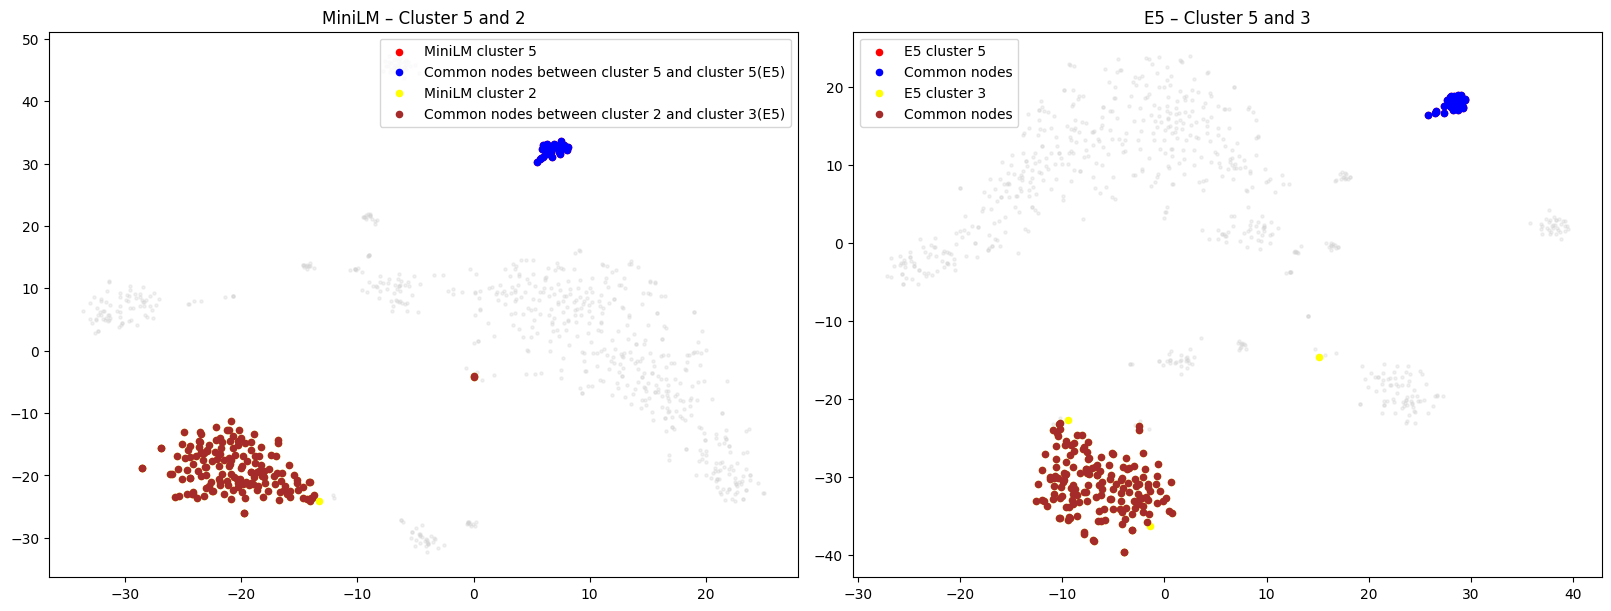

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ---- Masks & common indices ----
mask_MiniLM = cluster_MiniLM == c_MiniLM
mask_E5 = cluster_E5 == c_E5

mask_M_ver2 = cluster_MiniLM == 2
mask_E5_ver2 = cluster_E5 == 3

idx_common = np.array(
    list(cluster_index_MiniLM[c_MiniLM].intersection(
         cluster_index_E5[c_E5]))
)

idx_common_ver2 = np.array(
    list(cluster_index_MiniLM[2].intersection(
         cluster_index_E5[3]))
)
# ---- Figure ----
fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 6),
    constrained_layout=True
)

# ---- PCA (preprocessing) ----
pca_M = PCA(n_components=128, random_state=42)
pca_E = PCA(n_components=128, random_state=42)

X_pca_MiniLM = pca_M.fit_transform(embed_ver1)
X_pca_E5 = pca_E.fit_transform(embed_ver2)

# ---- t-SNE (IMPORTANT: separate instances) ----
tsne_M = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

tsne_E = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne_2d_MiniLM = tsne_M.fit_transform(X_pca_MiniLM)
X_tsne_2d_E5 = tsne_E.fit_transform(X_pca_E5)

# ===================== MiniLM =====================
ax0 = axes[0]

# background
ax0.scatter(
    X_tsne_2d_MiniLM[:, 0],
    X_tsne_2d_MiniLM[:, 1],
    c='lightgray',
    s=5,
    alpha=0.3
)

# cluster
ax0.scatter(
    X_tsne_2d_MiniLM[mask_MiniLM, 0],
    X_tsne_2d_MiniLM[mask_MiniLM, 1],
    c='red',
    s=20,
    label=f'MiniLM cluster {c_MiniLM}'
)

# common nodes
if len(idx_common) > 0:
    ax0.scatter(
        X_tsne_2d_MiniLM[idx_common, 0],
        X_tsne_2d_MiniLM[idx_common, 1],
        c='blue',
        s=20,
        label='Common nodes between cluster 5 and cluster 5(E5)'
    )

# cluster
ax0.scatter(
    X_tsne_2d_MiniLM[mask_M_ver2, 0],
    X_tsne_2d_MiniLM[mask_M_ver2, 1],
    c='yellow',
    s=20,
    label='MiniLM cluster 2'
)

# common nodes
if len(idx_common) > 0:
    ax0.scatter(
        X_tsne_2d_MiniLM[idx_common_ver2, 0],
        X_tsne_2d_MiniLM[idx_common_ver2, 1],
        c='brown',
        s=20,
        label='Common nodes between cluster 2 and cluster 3(E5)'
    )

ax0.set_title(f"MiniLM – Cluster {c_MiniLM} and 2")
ax0.legend()

# ===================== E5 =====================
ax1 = axes[1]

ax1.scatter(
    X_tsne_2d_E5[:, 0],
    X_tsne_2d_E5[:, 1],
    c='lightgray',
    s=5,
    alpha=0.3
)

ax1.scatter(
    X_tsne_2d_E5[mask_E5, 0],
    X_tsne_2d_E5[mask_E5, 1],
    c='red',
    s=20,
    label='E5 cluster 5'
)

if len(idx_common) > 0:
    ax1.scatter(
        X_tsne_2d_E5[idx_common, 0],
        X_tsne_2d_E5[idx_common, 1],
        c='blue',
        s=20,
        label='Common nodes'
    )

ax1.scatter(
    X_tsne_2d_E5[mask_E5_ver2, 0],
    X_tsne_2d_E5[mask_E5_ver2, 1],
    c='yellow',
    s=20,
    label='E5 cluster 3'
)

if len(idx_common) > 0:
    ax1.scatter(
        X_tsne_2d_E5[idx_common_ver2, 0],
        X_tsne_2d_E5[idx_common_ver2, 1],
        c='brown',
        s=20,
        label='Common nodes'
    )


ax1.set_title(f"E5 – Cluster {c_E5} and 3")
ax1.legend()

plt.show()


In [21]:
data_ver1.iloc[idx_common_ver2]['channel_name'].to_list()

['KapitalMusicTv',
 'HolaSoyGerman.',
 'wisinofficalVEVO',
 'DANIEL EL TRAVIESO VIDEOS',
 'DJ ALEX',
 'Carbon Fiber Music',
 'Tropicumbia Grupera',
 'Cartoon Club',
 'Karla Celis',
 'CheetoSenior',
 'ChinoNachoVEVO',
 'leorojasVEVO',
 'Carla Morrison',
 'CarlosRiveraVEVO',
 'CarlosVivesVEVO',
 'Doc Tops',
 'Carreras Diecast',
 'LosAngelesAzulesVEVO',
 'Karol Sevilla',
 'AFernandezVEVO',
 'RioromaVEVO',
 'JukiLop',
 'KarolGVEVO',
 'Daddy Yankee',
 'lesliegraceVEVO',
 'Bad Bunny',
 'ChristianNodalVEVO',
 'RomeoSantosVEVO',
 'JulianSerrano7',
 'Dai Hernandez',
 'UrbanoVideosTV',
 'MelendiOficialVEVO',
 'Adexe & Nau',
 'JenniRiveraVEVO',
 'GreeicyVEVO',
 'Jessi Uribe',
 'Jesus Adrian Romero',
 'PrinceRoyceVEVO',
 'Kronno Zomber',
 'Danny Ocean',
 'Darkar Company Studios',
 'Cosculluela El Principe',
 'Rvssian',
 'Creepypastas Everywhere',
 'JoeyMontanaVEVO',
 'Joga Sport',
 'LA DIVAZA',
 'Alex Rose',
 'AlfredoOlivasVEVO',
 'marcanthonyVEVO',
 'Valentino Pr',
 'David Solis Piano Music',
 'D